In [7]:
import shutil

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.regularizers import l1_l2
from tensorflow import keras
import tensorflow as tf
from tqdm import tqdm
import warnings
import os

from functions import *

pd.set_option('display.float_format', '{:.6f}'.format)

## Data

In [8]:
min_non_zero_pct = 0.5
window_size = 3
sequence_length = 10

df = load_and_merge()
df = remove_underpopulated_taxa(df, min_non_zero_pct)
df = standard_rolling_average(df, window_size)
df = feature_wise_scaling(df)

In [9]:
df

,659361,364179,3439402,181155,302746,4473763,175535,3887769,585227,189384,...,3304236,584137,193233,4334711,196664,583117,354850,subject_id,sampling_day,ind_time
E000823.4.0,0.000000,0.000160,0.288889,0.000000,0.000000,0.242718,0.010256,0.190476,0.000000,0.100671,...,0.029412,0.000000,0.040201,0.455696,0.059699,0.010154,0.064039,E000823,0.072046,0.072046
E000823.5.0,0.000000,0.000160,0.200000,0.000000,0.000000,0.199029,0.007692,0.119048,0.000000,0.120805,...,0.117647,0.000000,0.035804,0.398734,0.054162,0.010779,0.029557,E000823,0.100865,0.100865
E000823.5.7,0.000000,0.000180,0.200000,0.003724,0.000000,0.228155,0.007692,0.023810,0.000000,0.053691,...,0.117647,0.000000,0.034338,0.518987,0.060045,0.009685,0.019704,E000823,0.121037,0.121037
E000823.6.7,0.065636,0.000160,0.088889,0.016139,0.000000,0.121359,0.002564,0.023810,0.000000,0.080537,...,0.205882,0.000085,0.021566,0.386076,0.035127,0.006092,0.000000,E000823,0.149856,0.149856
E000823.8.5,0.065636,0.000220,0.177778,0.017381,0.000000,0.490291,0.020513,0.071429,0.000000,0.053691,...,0.176471,0.000085,0.050251,0.386076,0.061602,0.037334,0.000000,E000823,0.201729,0.201729
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
E014086.30.4,0.060355,0.080890,0.288889,0.007449,0.044379,0.111650,0.025641,0.476190,0.479017,0.503356,...,0.470588,0.055292,0.091290,0.253165,0.127531,0.423113,0.068966,E014086,0.832853,0.832853
E014086.32.4,0.060355,0.120524,0.622222,0.010552,0.077663,0.194175,0.071795,0.404762,0.880928,0.711409,...,0.441176,0.071990,0.142169,0.341772,0.345042,0.622876,0.285714,E014086,0.890490,0.890490
E014086.33.5,0.051679,0.141802,1.000000,0.011173,0.161243,0.436893,0.074359,0.619048,0.849198,0.906040,...,0.264706,0.057024,0.213358,0.373418,0.537809,0.756436,0.507389,E014086,0.922190,0.922190
E014086.34.4,0.021124,0.127490,0.977778,0.004345,0.160503,0.572816,0.071795,0.571429,0.761174,0.899329,...,0.294118,0.037543,0.241625,0.316456,0.631597,0.749125,0.610837,E014086,0.948127,0.948127


## Features and targets

In [10]:
number_test_sequences = 3

train_feats, train_targets, test_feats, test_targets, test_subjects = feats_and_targets(df, seq_length=sequence_length, n_test_seq=number_test_sequences)

The test subjects are ['E003188' 'E006781' 'E004709']


In [11]:
print(len(train_feats), len(train_targets))

268 268


In [13]:
train_targets = np.asarray(train_targets)
train_targets = pd.DataFrame(train_targets)
train_targets.columns = df.columns[~df.columns.isin(metadata_cols)]

In [14]:
train_targets

,659361,364179,3439402,181155,302746,4473763,175535,3887769,585227,189384,...,359650,130663,922761,3304236,584137,193233,4334711,196664,583117,354850
0,0.270464,0.000460,0.466667,0.040968,0.001479,0.029126,0.351282,0.238095,0.008871,0.369128,...,0.768349,0.071429,0.000187,0.235294,0.026751,0.459799,0.050633,0.350234,0.402712,0.433498
1,0.001886,0.028024,0.022222,0.004345,0.008876,0.033981,0.156410,0.023810,0.216308,0.087248,...,0.092890,0.008929,0.000080,0.264706,0.014370,0.196817,0.037975,0.073023,0.007873,0.009852
2,0.027537,0.000520,0.000000,0.057728,0.130178,0.000000,0.133333,0.142857,0.000000,0.315436,...,0.001147,0.000000,0.005548,0.176471,0.000170,0.012772,0.000000,0.000173,0.000187,0.118227
3,0.483968,0.000000,0.000000,0.105525,0.005178,0.004854,0.000000,0.619048,0.000341,0.557047,...,0.001147,0.000000,0.000453,0.705882,0.741516,0.002094,0.000000,0.003115,0.000094,0.118227
4,0.050170,0.000140,0.155556,0.027312,0.000740,0.092233,0.233333,0.071429,0.072671,0.275168,...,0.618119,0.062500,0.000080,0.029412,0.000937,0.219430,0.075949,0.202976,0.222913,0.428571
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
263,0.003395,0.000100,1.000000,0.018001,0.125000,0.635922,0.074359,0.000000,0.000341,0.060403,...,0.466743,0.383929,0.000053,0.000000,0.030443,0.105109,1.000000,0.114553,0.080324,0.019704
264,0.141456,0.032708,0.288889,0.000000,0.000000,0.058252,0.217949,0.071429,0.044012,0.174497,...,0.261468,0.000000,0.000000,0.205882,0.000114,0.201843,0.025316,0.350061,0.303330,0.019704
265,0.091664,0.006506,0.466667,0.056487,0.055473,0.155340,0.043590,0.000000,0.001365,0.000000,...,0.012615,0.526786,0.136822,0.000000,0.007100,0.060092,0.569620,0.144316,0.024838,0.000000
266,0.145605,0.000040,0.000000,0.042831,0.001479,0.000000,0.005128,0.119048,0.000000,0.114094,...,0.423165,0.000000,0.000453,0.264706,0.000227,0.002094,0.000000,0.000173,0.000187,0.024631


## The model

In [21]:
def fetch_model(seq_length):

    reg = 1e-8
    
    n_feats = len(train_feats[0][0])
    
    model = Sequential()
    model.add(keras.Input(shape=(seq_length, n_feats)))
    model.add(keras.layers.LSTM(1024, return_sequences=False, activation='relu'))
    model.add(keras.layers.Dense(512, activation="relu", kernel_regularizer=l1_l2(reg)))
    model.add(keras.layers.Dense(128, activation="relu", kernel_regularizer=l1_l2(reg)))
    model.add(keras.layers.Dense(1, activation="relu"))
    
    model.compile(optimizer="Adam", loss=loss, metrics=["mae", "mape"])
    
    return model

In [22]:
def compile_model(model, loss):
    model.compile(optimizer="Adam", loss=loss, metrics=["mae", "mape"])
    return model

In [23]:
#model = fetch_model()
#
#model.summary()
#
#model.save("/home/nate/temp/test_model_save.model")

## Individual model testbench

In [24]:
y_true = tf.constant([0])
y_pred = tf.constant([1])

loss = mae_ignore_zeros(false_positives_penalty_factor=0.3)
loss.call(y_true, y_pred)

<tf.Tensor: shape=(), dtype=float64, numpy=nan>

In [25]:
target_taxa = 364179

plot=False

if plot is True:
    plot_a_taxa_sequence(train_targets[target_taxa], title=f"Train sequence for taxa_idx {target_taxa}", color="blue")

In [26]:
n_epochs = 15

#loss = mae_ignore_zeros(false_positives_penalty_factor=0.3)
loss = "mae"

model = fetch_model(seq_length=sequence_length)
model = compile_model(model, loss)

model.fit(x=train_feats, y=train_targets[target_taxa], validation_split=0.05, epochs=n_epochs, verbose=1)

Epoch 1/15


2023-10-31 16:06:36.571586: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-10-31 16:06:36.613075: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f63dcb702a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-10-31 16:06:36.613107: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Ti, Compute Capability 8.6
2023-10-31 16:06:36.617714: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-10-31 16:06:36.630523: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-10-31 16:06:36.724895: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of th

8/8 [==============================] - 2s 42ms/step - loss: 7.6628 - mae: 0.0246 - mape: 56497.8398 - val_loss: 6.1742 - val_mae: 0.0190 - val_mape: 100.0000
Epoch 2/15
8/8 [==============================] - 0s 17ms/step - loss: 5.2394 - mae: 0.0244 - mape: 92.5197 - val_loss: 4.1325 - val_mae: 0.0190 - val_mape: 100.0000
Epoch 3/15
8/8 [==============================] - 0s 17ms/step - loss: 3.4668 - mae: 0.0244 - mape: 92.5197 - val_loss: 2.6875 - val_mae: 0.0190 - val_mape: 100.0000
Epoch 4/15
8/8 [==============================] - 0s 18ms/step - loss: 2.2351 - mae: 0.0244 - mape: 92.5197 - val_loss: 1.7086 - val_mae: 0.0190 - val_mape: 100.0000
Epoch 5/15
8/8 [==============================] - 0s 16ms/step - loss: 1.4133 - mae: 0.0244 - mape: 92.5197 - val_loss: 1.0694 - val_mae: 0.0190 - val_mape: 100.0000
Epoch 6/15
8/8 [==============================] - 0s 16ms/step - loss: 0.8835 - mae: 0.0244 - mape: 92.5197 - val_loss: 0.6646 - val_mae: 0.0190 - val_mape: 100.0000
Epoch 7/15
8

In [27]:
test_subjects

array(['E003188', 'E006781', 'E004709'], dtype=object)

In [28]:
target_subject_idx = 0
target_subject = test_subjects[target_subject_idx]

test_subject_feats = np.asarray(test_feats[target_subject])

test_subject_targets = pd.concat(test_targets[target_subject]).T
test_subject_targets.columns = df.columns[:-1]

1/1 [==============================] - 0s 112ms/step


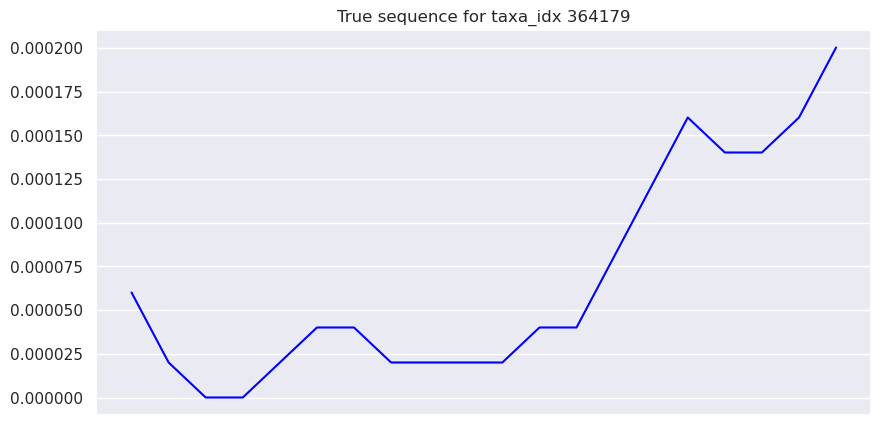

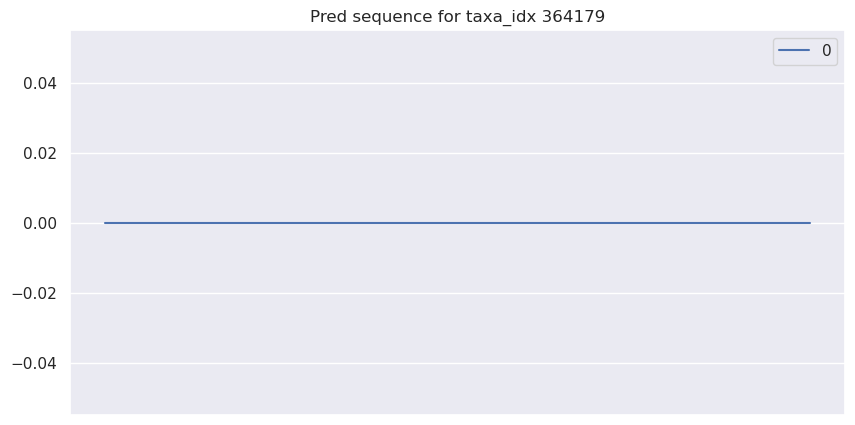

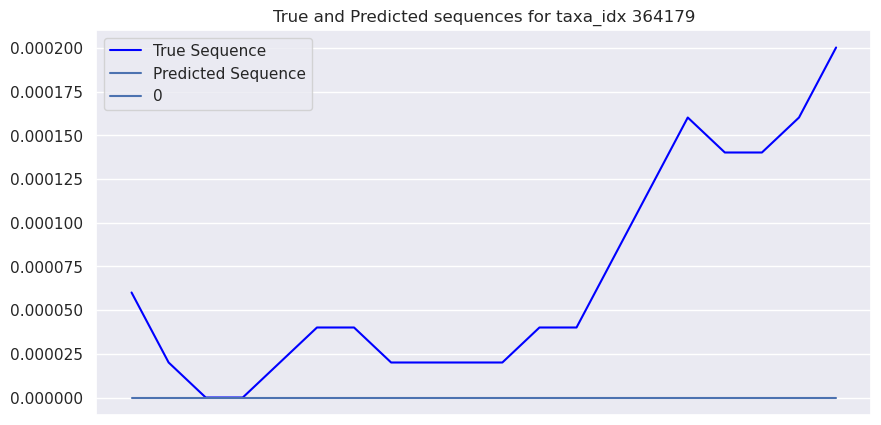

In [29]:
y_pred = model.predict(test_subject_feats)

true_sequence = test_subject_targets[target_taxa].reset_index(drop=True)
pred_sequence = y_pred

sequence_comparisson_graphs(true_sequence, pred_sequence, target_taxa)

## The Ensemble

In [55]:
class ensemble():
        
    def __init__(self, ensemble_name, loss, seq_length, overwrite_on_train=False):
        
        self.models_out_dir = f"{root_dir}/models/{ensemble_name}"
        self.overwrite_on_train = overwrite_on_train
        self.loss = loss
        self.seq_length = seq_length

        
    def train(self, X_sequences_train, y_targets_train, n_epochs):
        
        # hardcoded stuff
        ignore_cols = ["subject_id", "sampling_day", "ind_time"]
        
        if not os.path.exists(self.models_out_dir):
            os.mkdir(self.models_out_dir)
        else:
            if self.overwrite_on_train is False:
                raise Exception("This model dir already exists")
            else:
                print("Overwriting an existing model dir")
                shutil.rmtree(self.models_out_dir)
                os.mkdir(self.models_out_dir)
                
        for taxa_idx in tqdm(y_targets_train.columns, desc="Training models"):
            
            if taxa_idx not in ignore_cols:
            
                model = fetch_model(seq_length=self.seq_length)
                model = compile_model(model, loss)
                y_targets = y_targets_train[taxa_idx]
                model.fit(x=X_sequences_train, y=y_targets, validation_split=0.05, epochs=n_epochs, verbose=0)
                
                model.save(f"{self.models_out_dir}/{taxa_idx}.model")
            
                del model
            
    
    def load(self):
        
        self.model_dic = {}

        for model_dir in tqdm(os.listdir(self.models_out_dir), desc="Loading the models"):
            taxa_idx = int(model_dir.replace(".model", ""))
            
            if isinstance(loss, mae_ignore_zeros):
                model = tf.keras.models.load_model(f"{self.models_out_dir}/{taxa_idx}.model", compile=False)
                model = compile_model(model, loss)
            else:
                model = tf.keras.models.load_model(f"{self.models_out_dir}/{taxa_idx}.model")
                 
            self.model_dic[taxa_idx] = model
    
         
    def predict(self, X_sequences):
        
        if not hasattr(self, "model_dic"):
            self.load()
        
        n_sequences = len(X_sequences)
        
        pred_list = []
        for taxa_idx in tqdm(self.model_dic.keys(), desc="Predicting values"):
            model = self.model_dic[taxa_idx]
            pred_list.append(model.predict(X_sequences, verbose=0).reshape(n_sequences,))
            del(model)
            
        pred_df = pd.DataFrame(pred_list).T
            
        return pred_df

In [56]:
# Tensorflow does not play nice with my Linux machine, thus I am filtering out its warnings
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

#loss = mae_ignore_zeros(false_positives_penalty_factor=0.1)
loss = "mae"

model_ensemble = ensemble(ensemble_name="test_ensemble", loss=loss, overwrite_on_train=True, seq_length=sequence_length)

In [57]:
train_targets

,659361,364179,3439402,181155,302746,4473763,175535,3887769,585227,189384,...,359650,130663,922761,3304236,584137,193233,4334711,196664,583117,354850
0,0.270464,0.000460,0.466667,0.040968,0.001479,0.029126,0.351282,0.238095,0.008871,0.369128,...,0.768349,0.071429,0.000187,0.235294,0.026751,0.459799,0.050633,0.350234,0.402712,0.433498
1,0.001886,0.028024,0.022222,0.004345,0.008876,0.033981,0.156410,0.023810,0.216308,0.087248,...,0.092890,0.008929,0.000080,0.264706,0.014370,0.196817,0.037975,0.073023,0.007873,0.009852
2,0.027537,0.000520,0.000000,0.057728,0.130178,0.000000,0.133333,0.142857,0.000000,0.315436,...,0.001147,0.000000,0.005548,0.176471,0.000170,0.012772,0.000000,0.000173,0.000187,0.118227
3,0.483968,0.000000,0.000000,0.105525,0.005178,0.004854,0.000000,0.619048,0.000341,0.557047,...,0.001147,0.000000,0.000453,0.705882,0.741516,0.002094,0.000000,0.003115,0.000094,0.118227
4,0.050170,0.000140,0.155556,0.027312,0.000740,0.092233,0.233333,0.071429,0.072671,0.275168,...,0.618119,0.062500,0.000080,0.029412,0.000937,0.219430,0.075949,0.202976,0.222913,0.428571
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
263,0.003395,0.000100,1.000000,0.018001,0.125000,0.635922,0.074359,0.000000,0.000341,0.060403,...,0.466743,0.383929,0.000053,0.000000,0.030443,0.105109,1.000000,0.114553,0.080324,0.019704
264,0.141456,0.032708,0.288889,0.000000,0.000000,0.058252,0.217949,0.071429,0.044012,0.174497,...,0.261468,0.000000,0.000000,0.205882,0.000114,0.201843,0.025316,0.350061,0.303330,0.019704
265,0.091664,0.006506,0.466667,0.056487,0.055473,0.155340,0.043590,0.000000,0.001365,0.000000,...,0.012615,0.526786,0.136822,0.000000,0.007100,0.060092,0.569620,0.144316,0.024838,0.000000
266,0.145605,0.000040,0.000000,0.042831,0.001479,0.000000,0.005128,0.119048,0.000000,0.114094,...,0.423165,0.000000,0.000453,0.264706,0.000227,0.002094,0.000000,0.000173,0.000187,0.024631


In [58]:
model_ensemble.train(X_sequences_train=train_feats, y_targets_train=train_targets, n_epochs=15)

Overwriting an existing model dir


Training models: 100%|██████████| 202/202 [18:24<00:00,  5.47s/it]


## Validation

In [59]:
test_subjects

array(['E003188', 'E006781', 'E004709'], dtype=object)

In [60]:
target_subject_idx = 0
target_subject = test_subjects[target_subject_idx]

target_subject_y_test_df = pd.concat(test_targets[target_subject], axis=1).T
target_subject_y_test_df.columns = df.columns[:-1]

target_subject_y_test_df = target_subject_y_test_df.reset_index(drop=True).drop(columns=["subject_id", "sampling_day"])
target_subject_y_test_df

,659361,364179,3439402,181155,302746,4473763,175535,3887769,585227,189384,...,359650,130663,922761,3304236,584137,193233,4334711,196664,583117,354850
0,0.319502,0.000060,0.711111,0.036623,0.030325,0.330097,0.012821,0.095238,0.000000,0.288591,...,0.000000,0.133929,0.002587,0.176471,0.000000,0.051089,0.322785,0.075099,0.009810,0.182266
1,0.125990,0.000020,0.511111,0.015518,0.049556,0.266990,0.007692,0.119048,0.000000,0.375839,...,0.001147,0.133929,0.002080,0.352941,0.000000,0.029104,0.126582,0.037723,0.004155,0.211823
2,0.057337,0.000000,0.422222,0.009311,0.040680,0.174757,0.005128,0.071429,0.000000,0.395973,...,0.244266,0.062500,0.292207,0.441176,0.000000,0.021566,0.107595,0.023880,0.002656,0.270936
3,0.010562,0.000000,0.200000,0.006207,0.079142,0.281553,0.002564,0.190476,0.000000,0.463087,...,0.291284,0.125000,0.292927,0.411765,0.000000,0.012353,0.107595,0.016958,0.001125,0.221675
4,0.000000,0.000020,0.266667,0.001862,0.560651,0.364078,0.002564,0.166667,0.000000,0.375839,...,0.636468,0.133929,0.292874,0.235294,0.000028,0.031407,0.278481,0.040318,0.000812,0.192118
5,0.000000,0.000040,0.266667,0.038485,0.990385,0.364078,0.002564,0.547619,0.000000,0.791946,...,0.732798,0.133929,0.002000,0.441176,0.000057,0.029941,0.265823,0.040145,0.000687,0.399015
6,0.000000,0.000040,0.244444,0.036623,1.000000,0.126214,0.000000,0.690476,0.000000,0.798658,...,0.909404,0.062500,0.002987,0.352941,0.000057,0.022404,0.196203,0.029071,0.000562,0.423645
7,0.026405,0.000020,0.000000,0.044072,0.497781,0.082524,0.000000,0.738095,0.015012,0.919463,...,0.697248,0.133929,0.002987,0.411765,0.000085,0.004816,0.044304,0.023360,0.000781,0.536946
8,0.027537,0.000020,0.022222,0.007449,0.068047,0.087379,0.000000,0.428571,0.045377,0.442953,...,0.397936,0.151786,0.002454,0.088235,0.000057,0.006072,0.044304,0.027859,0.001156,0.315271
9,0.028291,0.000020,0.022222,0.008690,0.009615,0.111650,0.000000,0.142857,0.052542,0.241611,...,0.193807,0.169643,0.000107,0.117647,0.000057,0.006491,0.056962,0.029244,0.001000,0.349754


In [61]:
target_subject_feats = np.asarray(test_feats[target_subject])
target_subject_y_pred_df = model_ensemble.predict(target_subject_feats)

Predicting values: 100%|██████████| 202/202 [00:28<00:00,  7.08it/s]


In [62]:
target_subject_y_pred_df = target_subject_y_pred_df.reset_index(drop=True)
target_subject_y_pred_df.columns = target_subject_y_test_df.columns
target_subject_y_pred_df

,659361,364179,3439402,181155,302746,4473763,175535,3887769,585227,189384,...,359650,130663,922761,3304236,584137,193233,4334711,196664,583117,354850
0,0.000000,0.000000,0.276346,0.000000,0.000000,0.104395,0.024305,0.092560,0.000000,0.099395,...,0.147108,0.000000,0.000000,0.114197,0.000000,0.000000,0.000000,0.071794,0.143728,0.094243
1,0.000000,0.000000,0.319405,0.000000,0.000000,0.135862,0.024365,0.122320,0.000000,0.119690,...,0.166053,0.000000,0.000000,0.130741,0.000000,0.000000,0.000000,0.072293,0.139467,0.085029
2,0.000000,0.000000,0.296482,0.000000,0.000000,0.135678,0.025798,0.166028,0.000000,0.179656,...,0.164943,0.000000,0.000000,0.172023,0.000000,0.000000,0.000000,0.068131,0.131335,0.095078
3,0.000000,0.000000,0.268952,0.000000,0.000000,0.128097,0.029586,0.197486,0.000000,0.247615,...,0.237940,0.000000,0.000000,0.203403,0.000000,0.000000,0.000000,0.066115,0.117052,0.116509
4,0.000000,0.000000,0.237391,0.000000,0.000000,0.132967,0.028420,0.227807,0.000000,0.324031,...,0.259060,0.000000,0.000000,0.214606,0.000000,0.000000,0.000000,0.060454,0.103793,0.128291
5,0.000000,0.000000,0.243879,0.000000,0.000000,0.166790,0.021414,0.236859,0.000000,0.367470,...,0.309365,0.000000,0.000000,0.176532,0.000000,0.000000,0.000000,0.056491,0.087533,0.156842
6,0.000000,0.000000,0.241513,0.000000,0.000000,0.202306,0.011921,0.333769,0.000000,0.551560,...,0.309309,0.000000,0.000000,0.208719,0.000000,0.000000,0.000000,0.048199,0.064513,0.229844
7,0.000000,0.000000,0.257829,0.000000,0.000000,0.208761,0.008056,0.415060,0.000000,0.733029,...,0.330416,0.000000,0.000000,0.286717,0.000000,0.000000,0.000000,0.048397,0.053846,0.360400
8,0.000000,0.000000,0.221998,0.000000,0.000000,0.192823,0.006572,0.448798,0.000000,0.836613,...,0.287511,0.000000,0.000000,0.358777,0.000000,0.000000,0.000000,0.053316,0.044138,0.454361
9,0.000000,0.000000,0.179662,0.000000,0.000000,0.168757,0.008009,0.319465,0.000000,0.643813,...,0.183654,0.000000,0.000000,0.302980,0.000000,0.000000,0.000000,0.068400,0.044699,0.463017


In [72]:
non_predicted_taxa = [col for col in test_subject_y_pred_df.columns if all(test_subject_y_pred_df[col] == 0.0)]
n_non_predicted_taxa = len(non_predicted_taxa)

print(f"Total taxa not predicted: {len(non_predicted_taxa)}, {(n_non_predicted_taxa/len(test_subject_targets_df.columns)) * 100}% of all taxa")

Total taxa not predicted: 103, 50.49019607843137% of all taxa


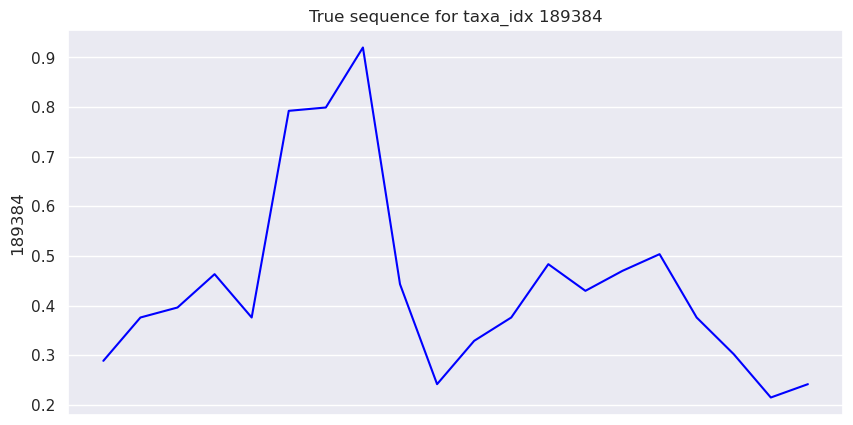

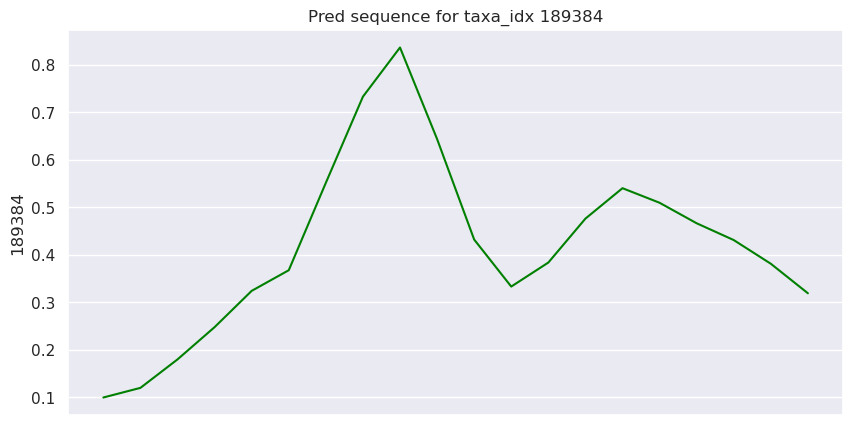

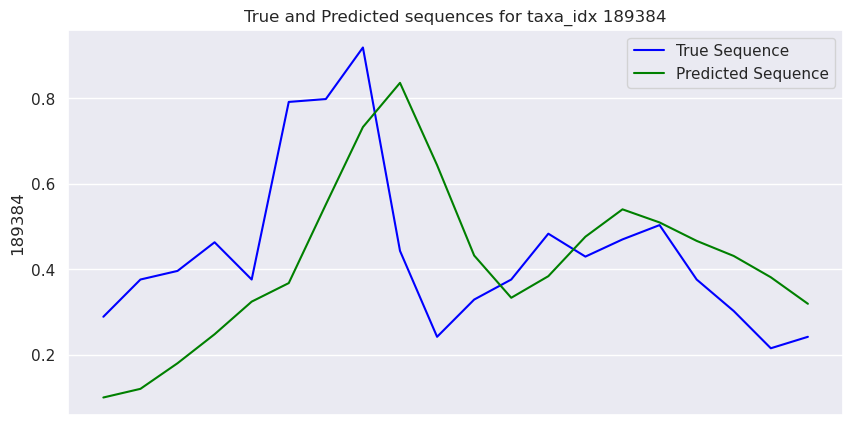

In [73]:
target_taxa = 189384

true_sequence = target_subject_y_test_df[target_taxa].reset_index(drop=True)
pred_sequence = target_subject_y_pred_df[target_taxa]

sequence_comparisson_graphs(true_sequence, pred_sequence, target_taxa)

In [74]:
def fetch_subject_y_true_and_y_pred(test_subjects, model, df, target_subject_idx, test_feats, test_targets):
    
    cols_true = df.columns[df.columns != "subject_id"]
    cols_pred = df.columns[~df.columns.isin(metadata_cols)]
    
    target_subject = test_subjects[target_subject_idx]
    
    test_subject_feats = np.asarray(test_feats[target_subject])
    test_subject_targets_df = pd.concat(test_targets[target_subject], axis=1).T
    
    test_subject_targets_df.columns = cols_true
    test_subject_y_pred = model.predict(test_subject_feats)
    
    test_subject_y_pred_df = pd.DataFrame(test_subject_y_pred)
    test_subject_y_pred_df.columns = cols_pred
    test_subject_y_pred_df.index = test_subject_targets_df.index

    return test_subject_targets_df, test_subject_y_pred_df

In [75]:
subjects_error_dfs = []
for target_subject_idx in range(len(test_subjects)):
    
    test_subject_targets_df, test_subject_y_pred_df = fetch_subject_y_true_and_y_pred(test_subjects, model_ensemble, df, target_subject_idx, test_feats, test_targets)

    errors_df = calculate_percentage_errors(test_subject_y_pred_df, test_subject_targets_df)
    subjects_error_dfs.append(errors_df)
    
errors_df = pd.concat(subjects_error_dfs)

Predicting values: 100%|██████████| 202/202 [00:08<00:00, 24.14it/s]


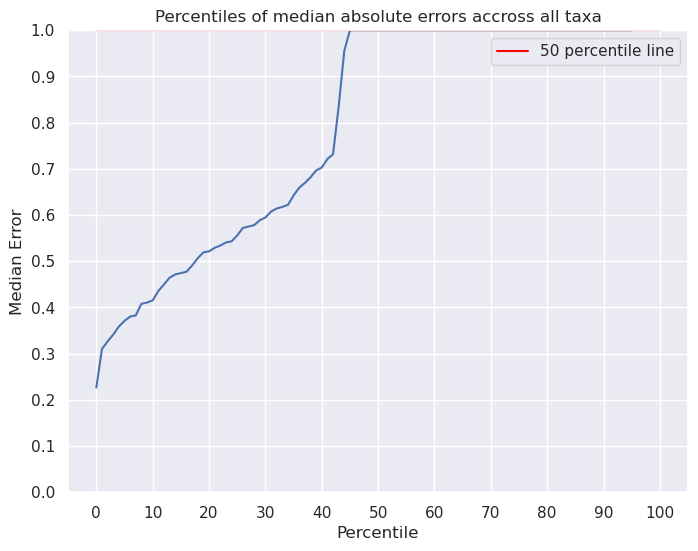

In [76]:
percentile_graph(errors_df, "accross all taxa", y_top_lim=1)

In [77]:
only_predicted_taxa = test_subject_y_pred_df.columns[~(test_subject_y_pred_df.columns.isin(non_predicted_taxa))]
only_predicted_errors = errors_df[only_predicted_taxa]
only_predicted_errors.describe()

,3439402,4473763,175535,3887769,189384,309391,844375,509416,194236,514523,...,366794,177567,367433,193484,577170,359650,3304236,196664,583117,354850
count,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,...,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000
unique,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,...,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000
top,0.611389,0.683743,0.895794,0.028124,0.655583,0.630657,0.092179,0.721654,0.807169,803703069.686890,...,1165113300.085068,1477927416.563034,767104625.701904,0.444131,0.552563,1471082270.145416,0.352886,0.044016,13.651053,0.482936
freq,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


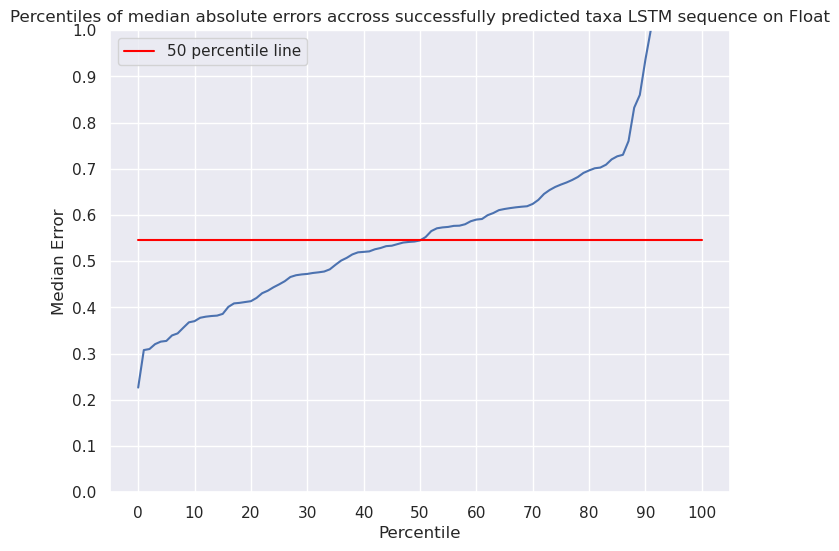

In [78]:
percentile_graph(only_predicted_errors, "accross successfully predicted taxa LSTM sequence on Float", y_top_lim=1)

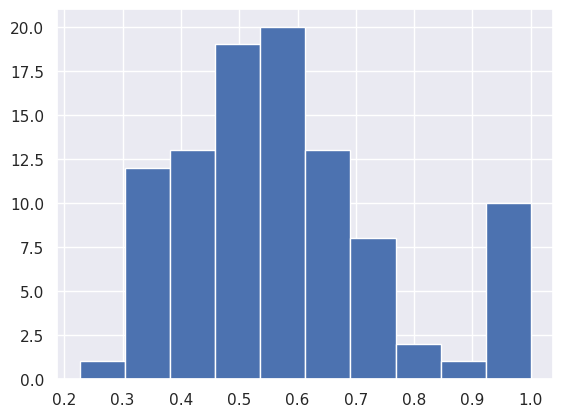

In [79]:
plt.hist(only_predicted_errors.median().clip(0, 1))
plt.show()

In [80]:
population_rates = calculate_non_zero_value_percentages(df).drop(['subject_id', 'sampling_day'])

What are the average population rates in the taxa that are predicted by this model compared to the ones that arent?

In [81]:
population_rates[non_predicted_taxa].mean()

0.8518809510447651

In [82]:
population_rates[only_predicted_taxa].mean()

0.8567369261010881

Among the predicted taxa, is the median error somehow related to the population rate?

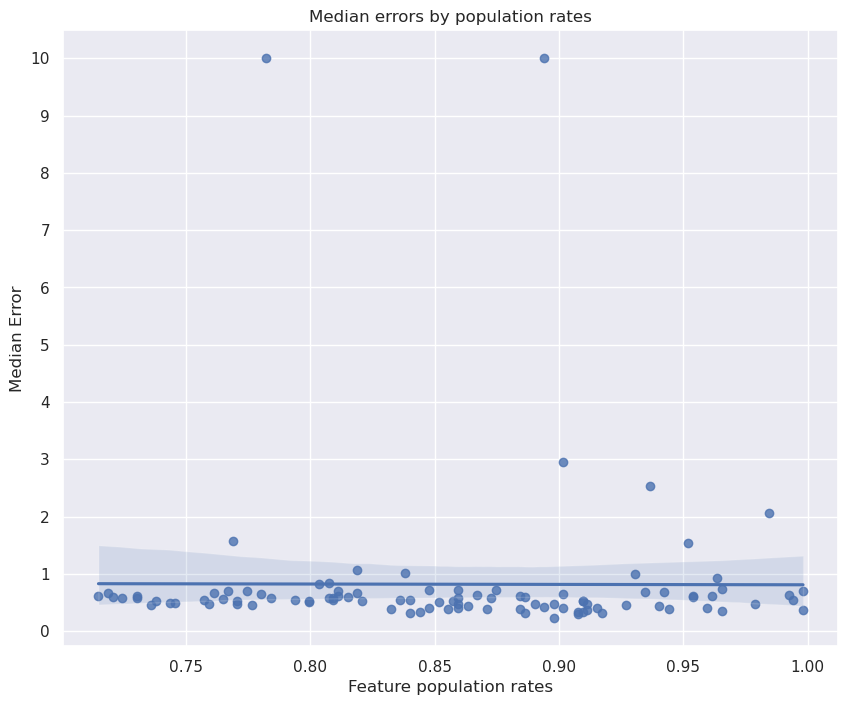

In [83]:
median_errors_by_population_rate(df, only_predicted_errors, only_predicted_taxa)